# Import Libraries and Packages
Pandas, numpy, NLTK, gensim, spacy, pyLDavis, Matplotlib
and prepare stopwords - restart runtime in order to apply packages installed before continuing with the rest of the code.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download("all")
#Upgrade Pandas 
!pip install --upgrade pandas
!pip install pyLDAvis
!pip install openpyxl --upgrade --pre
#Mallet's Version of Topic Modelling 
!pip install --upgrade gensim==3.8
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python3 -m spacy download en

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import openpyxl 

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

# Import Notebook
Load dataset and Initiate dataframe
(Do remember to upgrade pandas in order to avoid import optional dependency error when attempting to dropna(inplace=True) )

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/IS424 Depression Project/model_data_v2.xlsx")
df = df.drop("Unnamed: 0", axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38362 entries, 0 to 38361
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        38259 non-null  object 
 1   depression  38362 non-null  float64
dtypes: float64(1), object(1)
memory usage: 599.5+ KB


In [5]:
df.dropna(inplace=True)

In [6]:
df = df[df['depression'] == 1]

#Convert document into a list of tokens

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['text']))

#Build Bigram and Trigram models

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=30) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=30)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#Pre-processing of data
remove stop words, create bigram, create trigram and lemmatization

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initiate spacy for lemmatization
nlp = spacy.load('en', disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


#Create dictionary(id2words) and corpus for Topic Modelling


In [11]:
# Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)
id2word = corpora.Dictionary(data_words_bigrams)
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#Build LDA Model

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#Visualise 20 Topics from our Topic Modelling

In [13]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.201*"exist" + 0.143*"god" + 0.091*"must" + 0.041*"suicide_attempt" + '
  '0.038*"bottle" + 0.033*"tbh" + 0.028*"fade" + 0.016*"mirror" + '
  '0.010*"brain_damage" + 0.008*"creature"'),
 (1,
  '0.117*"doctor" + 0.076*"speak" + 0.046*"genuinely" + 0.042*"panic_attack" + '
  '0.040*"guilt" + 0.029*"misery" + 0.028*"simple" + 0.027*"terrify" + '
  '0.024*"asshole" + 0.024*"invite"'),
 (2,
  '0.168*"continue" + 0.092*"joke" + 0.089*"contact" + 0.082*"convince" + '
  '0.053*"commit" + 0.032*"torture" + 0.018*"counsel" + 0.011*"dramatic" + '
  '0.009*"bank" + 0.007*"nothing_left"'),
 (3,
  '0.114*"pain" + 0.051*"body" + 0.038*"brain" + 0.033*"man" + 0.028*"heart" + '
  '0.028*"low" + 0.028*"stress" + 0.028*"word" + 0.028*"morning" + '
  '0.026*"woman"'),
 (4,
  '0.267*"please" + 0.132*"alive" + 0.069*"society" + 0.046*"goal" + '
  '0.033*"everybody" + 0.032*"slow" + 0.031*"desperate" + 0.026*"illness" + '
  '0.022*"knife" + 0.021*"final"'),
 (5,
  '0.018*"would" + 0.018*"even" + 0.0

#Compute model perplexity and coherence score

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.556786027422717

Coherence Score:  0.35505800352728956


#Visualise Topic keywords
examine the produced topics and the associated keywords.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.342060 -0.253614       1        1  65.557391
16     0.266193 -0.128091       2        1   8.308131
10     0.268732 -0.087459       3        1   7.612603
17     0.166345  0.245690       4        1   3.727360
12     0.162755  0.202474       5        1   3.346548
3      0.111604  0.137344       6        1   2.622669
8      0.104892  0.130648       7        1   2.188318
15     0.025874  0.043123       8        1   1.497301
13    -0.051629 -0.002832       9        1   0.798209
1     -0.059024 -0.006152      10        1   0.767480
4     -0.083329 -0.015239      11        1   0.585423
7     -0.096895 -0.019712      12        1   0.536320
14    -0.099518 -0.020586      13        1   0.527947
19    -0.127156 -0.027872      14        1   0.394463
6     -0.137484 -0.030121      15        1   0.357408
0     -0.132585 -0.029074      16        1   0.344961
2     -0.145150 -0.031636      17        1   0.319941
9     -0.147820 -0.032134      18        1   0.306778
18    -0.177621 -0.036582      19        1   0.147350
11    -0.190241 -0.038174      20        1   0.053400, topic_info=          Term          Freq         Total Category  logprob  loglift
239     people  12465.000000  12465.000000  Default  30.0000  30.0000
568       work   7606.000000   7606.000000  Default  29.0000  29.0000
159       fuck   6969.000000   6969.000000  Default  28.0000  28.0000
152        die   7021.000000   7021.000000  Default  27.0000  27.0000
5       friend  10991.000000  10991.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
2339      fear      0.013274      0.989205  Topic20 -10.8111   3.2240
2301       tho      0.013274      0.989124  Topic20 -10.8111   3.2241
7423  remotely      0.013274      0.989103  Topic20 -10.8111   3.2241
2893       bos      0.013274      0.989105  Topic20 -10.8111   3.2241
5886   minimal      0.013274      0.989097  Topic20 -10.8111   3.2241

[823 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
726       4  0.998695         abuse
1490      4  0.999106       abusive
1405     16  0.978053  academically
113       8  0.998555        accept
1026     14  0.991364       account
...     ...       ...           ...
1649     12  0.963649          yoga
1680      4  0.999149         young
450       7  0.996779        zoloft
1809     18  0.985330        zombie
1926     15  0.941371          zone

[542 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 17, 11, 18, 13, 4, 9, 16, 14, 2, 5, 8, 15, 20, 7, 1, 3, 10, 19, 12])

#Building LDA Mallet Model 

In [17]:
#Mallet's Version of Topic Modelling 
!pip install --upgrade gensim==3.8

In [18]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [19]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-11-18 01:58:38--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  8.10MB/s    in 1.9s    

2021-11-18 01:58:40 (8.10 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [20]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
corpus_path = 'transcripts' # you need to change this path to the directory containing your corpus of .txt files

In [21]:
import os
from gensim.models.wrappers import LdaMallet
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

#Visulalise topic keywords derived from LDA Mallet Model

In [22]:
from pprint import pprint
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(9,
  [('live', 0.03862370289459312),
   ('money', 0.036198798470780995),
   ('eat', 0.028814855270344074),
   ('move', 0.02354997269251775),
   ('leave', 0.022545057345712726),
   ('place', 0.01955215729109776),
   ('spend', 0.0156198798470781),
   ('pay', 0.015161114145275805),
   ('house', 0.014330966684871655),
   ('car', 0.014265428727471326)]),
 (5,
  [('issue', 0.024176705132803105),
   ('problem', 0.02312187506592688),
   ('point', 0.016581928651294278),
   ('mental_health', 0.014240205902829053),
   ('struggle', 0.013965950085441235),
   ('situation', 0.01375498407206599),
   ('support', 0.013649501065378367),
   ('due', 0.012657960802514715),
   ('mental', 0.012236028775764225),
   ('state', 0.01063268707411236)]),
 (18,
  [('hate', 0.1069680193988196),
   ('good', 0.093219563526559),
   ('bad', 0.07688612343871529),
   ('thing', 0.06961156608866724),
   ('happy', 0.05721279224047216),
   ('deserve', 0.026078601820926934),
   ('hurt', 0.025003431394976437),
   ('person', 0.0

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

#Finding the optimal number of topics
Compare the coherence score and select the optimal number of topics

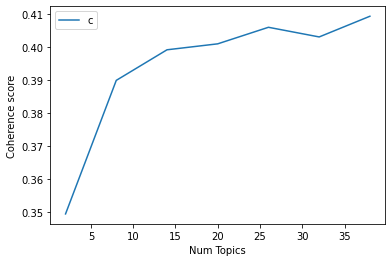

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
 # Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3495
Num Topics = 8  has Coherence Value of 0.3899
Num Topics = 14  has Coherence Value of 0.3992
Num Topics = 20  has Coherence Value of 0.401
Num Topics = 26  has Coherence Value of 0.406
Num Topics = 32  has Coherence Value of 0.4031
Num Topics = 38  has Coherence Value of 0.4093


In [27]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.071*"stop" + 0.069*"pain" + 0.062*"bad" + 0.038*"hurt" + 0.032*"scar" + '
  '0.024*"cut" + 0.022*"back" + 0.021*"happen" + 0.021*"leave" + 0.019*"fear"'),
 (1,
  '0.044*"thing" + 0.040*"post" + 0.031*"write" + 0.027*"lot" + 0.027*"read" + '
  '0.025*"find" + 0.018*"give" + 0.018*"kind" + 0.017*"advice" + '
  '0.014*"stuff"'),
 (2,
  '0.079*"year" + 0.045*"school" + 0.027*"start" + 0.026*"parent" + '
  '0.021*"college" + 0.019*"fail" + 0.015*"study" + 0.014*"future" + '
  '0.012*"grade" + 0.011*"class"'),
 (3,
  '0.133*"work" + 0.080*"job" + 0.033*"money" + 0.023*"move" + 0.020*"month" + '
  '0.020*"home" + 0.018*"pay" + 0.016*"lose" + 0.015*"back" + 0.015*"find"'),
 (4,
  '0.147*"die" + 0.109*"kill" + 0.049*"end" + 0.049*"suicide" + 0.040*"live" + '
  '0.039*"death" + 0.028*"plan" + 0.022*"dead" + 0.022*"alive" + '
  '0.017*"suicidal"'),
 (5,
  '0.076*"good" + 0.076*"thing" + 0.075*"happy" + 0.040*"reason" + 0.036*"sad" '
  '+ 0.032*"long" + 0.030*"happen" + 0.024*"idk" + 0.0

#Visualise Topic keywords
examine the produced topics and the associated keywords.

In [28]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(mallet_to_lda(ldamallet), corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.155752 -0.116001       1        1  5.205302
19     0.169234 -0.071012       2        1  5.201499
7     -0.037781  0.169610       3        1  5.163910
18     0.177946 -0.116334       4        1  5.071350
5      0.027088 -0.036801       5        1  5.064117
8      0.177806  0.162556       6        1  5.050415
0     -0.186358 -0.113378       7        1  5.038273
15    -0.258872 -0.015483       8        1  5.023174
3     -0.021536 -0.025610       9        1  5.012200
4      0.057591 -0.216342      10        1  5.001786
12    -0.127908  0.005502      11        1  4.997472
11     0.091922  0.188990      12        1  4.983921
13     0.120261 -0.089821      13        1  4.957355
17    -0.122109  0.090327      14        1  4.942263
6      0.169589 -0.125319      15        1  4.913682
1      0.122202  0.196246      16        1  4.897794
2     -0.108661 -0.099357      17        1  4.892860
10    -0.028609  0.164067      18        1  4.869334
16     0.069549 -0.083910      19        1  4.868363
9     -0.135601  0.132070      20        1  4.844931, topic_info=         Term          Freq         Total Category  logprob  loglift
239    people  14668.000000  14668.000000  Default  30.0000  30.0000
5      friend  11616.000000  11616.000000  Default  29.0000  29.0000
142   anymore  10795.000000  10795.000000  Default  28.0000  28.0000
568      work   9239.000000   9239.000000  Default  27.0000  27.0000
159      fuck   8991.000000   8991.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
1360      run    336.465162    857.296201  Topic20  -5.1785   2.0919
219       day    593.378483  12791.780078  Topic20  -4.6112  -0.0435
290      back    434.274802   6302.414342  Topic20  -4.9234   0.3522
157      find    429.058287   5926.904734  Topic20  -4.9354   0.4016
416      give    369.068375   6266.869313  Topic20  -5.0860   0.1952

[1738 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3013      6  1.315896   abovemake
1365      1  0.994106      abroad
136       5  0.133001  absolutely
136       8  0.097457  absolutely
136      13  0.076819  absolutely
...     ...       ...         ...
1680      1  0.184312       young
1680     11  0.647162       young
1680     13  0.168780       young
2795      4  0.699578       zelda
450       7  0.999884      zoloft

[2748 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 20, 8, 19, 6, 9, 1, 16, 4, 5, 13, 12, 14, 18, 7, 2, 3, 11, 17, 10])

#Find dominant topics in each sentance

In [30]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts['text'])
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1024,"stop, pain, bad, hurt, scar, cut, back, happen...",recently breakup say still friend say try talk...
1,1,2.0,0.1278,"year, school, start, parent, college, fail, st...",navigate feeling new feeling stretch understan...
2,2,17.0,0.0943,"depression, bad, feeling, felt, depress, depre...",month already tell depress week nothing partic...
3,3,15.0,0.1028,"anymore, fuck, hate, shit, fucking, stupid, li...",exhausted finally rest maybe thing start settl...
4,4,8.0,0.1174,"people, thing, enjoy, good, find, person, chan...",severly bully since till result depress misant...
5,5,8.0,0.1092,"people, thing, enjoy, good, find, person, chan...",year old good friend tire problem bully little...
6,6,11.0,0.0732,"day, eat, body, put, energy, walk, dog, barely...",mom camp hate hate day good midnight call cps ...
7,7,11.0,0.1008,"day, eat, body, put, energy, walk, dog, barely...",help idea simple healthy meal depressed simple...
8,8,13.0,0.1409,"thought, mind, head, lose, day, brain, back, f...",loom around corner always come back wave moon ...
9,9,6.0,0.0672,"family, mom, parent, dad, kid, mother, year, l...",foodand thing judge weird view maybe delusiona...


#Find the most representative document for each topic

In [31]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3558,"stop, pain, bad, hurt, scar, cut, back, happen...",friend irl friend untill year parent stuff som...
1,1.0,0.7371,"thing, post, write, lot, read, find, give, kin...",depress long see therapist take pill since for...
2,2.0,0.4257,"year, school, start, parent, college, fail, st...",constant nagging feeling bear wrong something ...
3,3.0,0.7133,"work, job, money, move, month, home, pay, lose...",shower wash hair week doctor issue wait keep t...
4,4.0,0.7995,"die, kill, end, suicide, live, death, plan, de...",struggle shit whole sometimes much man usually...


#Topic distribution across documents

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"stop, pain, bad, hurt, scar, cut, back, happen...",1044.0,0.0513
1.0,2.0,"year, school, start, parent, college, fail, st...",777.0,0.0382
2.0,17.0,"depression, bad, feeling, felt, depress, depre...",1006.0,0.0494
3.0,15.0,"anymore, fuck, hate, shit, fucking, stupid, li...",1131.0,0.0556
4.0,8.0,"people, thing, enjoy, good, find, person, chan...",1787.0,0.0878
...,...,...,...,...
20358.0,NaN,NaN,NaN,NaN
20359.0,NaN,NaN,NaN,NaN
20360.0,NaN,NaN,NaN,NaN
20361.0,NaN,NaN,NaN,NaN


In [33]:
df_dominant_topics.dropna()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"stop, pain, bad, hurt, scar, cut, back, happen...",1044.0,0.0513
1.0,2.0,"year, school, start, parent, college, fail, st...",777.0,0.0382
2.0,17.0,"depression, bad, feeling, felt, depress, depre...",1006.0,0.0494
3.0,15.0,"anymore, fuck, hate, shit, fucking, stupid, li...",1131.0,0.0556
4.0,8.0,"people, thing, enjoy, good, find, person, chan...",1787.0,0.0878
5.0,8.0,"people, thing, enjoy, good, find, person, chan...",819.0,0.0402
6.0,11.0,"day, eat, body, put, energy, walk, dog, barely...",1088.0,0.0535
7.0,11.0,"day, eat, body, put, energy, walk, dog, barely...",958.0,0.0471
8.0,13.0,"thought, mind, head, lose, day, brain, back, f...",777.0,0.0382
9.0,6.0,"family, mom, parent, dad, kid, mother, year, l...",611.0,0.0300


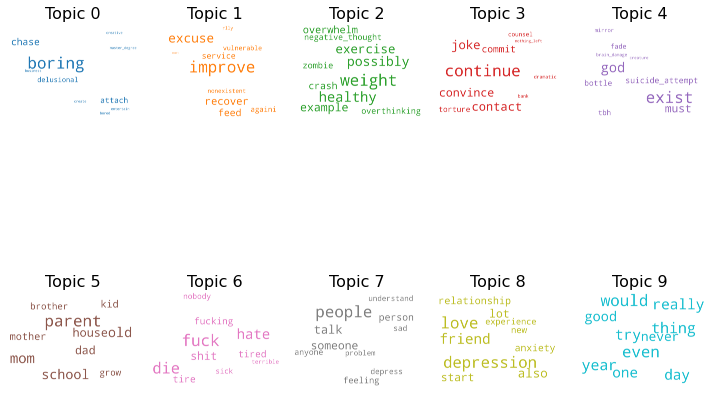

In [34]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
#DO NOT RUN THIS LINE OF CODE
df_dominant_topics.to_excel("/content/drive/MyDrive/Colab Notebooks/IS424 Depression Project/text_with_topic.xlsx")